In [0]:
# Import the necessary libraries
import csv, os, calendar
from io import StringIO
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [0]:
dbutils.fs.ls('/FileStore/tables/')

[FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709150392000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/account-models_1/', name='account-models_1/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1706721085000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations-1.zip', name='activations-1.zip', size=8411369, modificationTime=1707257309000),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1706718502000),
 FileInfo(path='dbfs:/FileStore/tables/c

In [0]:
def copy_and_unzip(file_root, file_names, destination_path):
    for file_name in file_names:
        # Construct full source path
        source_path = f"{file_root}/{file_name}"
        
        # Copy zip file from source to destination
        dbutils.fs.cp(source_path, 'file:/tmp/')
        
        # Unzip the file
        unzip_cmd = f'unzip -o -d /tmp/ /tmp/{file_name}'  # '-o' flag to overwrite existing files
        os.system(unzip_cmd)
        
        # Get the name of the extracted file
        extracted_file_name = os.path.splitext(file_name)[0]
        
        # Copy the extracted file to destination
        dbutils.fs.cp(f"file:/tmp/{extracted_file_name}.csv", destination_path)

In [0]:
# Use the function to unzip the Clinic Trial and Pharma zip files
file_root = "/FileStore/tables"
file_names = ["clinicaltrial_2020.zip", "clinicaltrial_2021.zip", "clinicaltrial_2023.zip", "pharma.zip"]
destination_path = "/FileStore/tables/"

copy_and_unzip(file_root, file_names, destination_path)

Archive:  /tmp/clinicaltrial_2020.zip
  inflating: /tmp/clinicaltrial_2020.csv  
Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  
Archive:  /tmp/clinicaltrial_2023.zip
  inflating: /tmp/clinicaltrial_2023.csv  
Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
dbutils.fs.ls('/FileStore/tables/')

[FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709150392000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/account-models_1/', name='account-models_1/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1706721085000),
 FileInfo(path='dbfs:/FileStore/tables/activations/', name='activations/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/activations-1.zip', name='activations-1.zip', size=8411369, modificationTime=1707257309000),
 FileInfo(path='dbfs:/FileStore/tables/activations.zip', name='activations.zip', size=8411369, modificationTime=1706718502000),
 FileInfo(path='dbfs:/FileStore/tables/c

In [0]:
dbutils.fs.head("/FileStore/tables/clinicaltrial_2023.csv")

[Truncated to first 65536 bytes]


'"Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,\r\n"NCT03630471\tEffectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India\tPRIDE\tCOMPLETED\tMental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)\tBEHAVIORAL: PRIDE \'Step 1\' problem-solving intervention|BEHAVIORAL: Enhanced usual care\tSangath\tHarvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine\t250.0\tOTHER\tINTERVENTIONAL\tAllocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT\t2018-08-20\t2019-02-28",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [0]:
dbutils.fs.head("/FileStore/tables/pharma.csv")

[Truncated to first 65536 bytes]


'"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"\n"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company\'s car

In [0]:
def clean_and_split_data(spark, file_path):
    # Load data from CSV file
    rdd = spark.sparkContext.textFile(file_path)
    
    # Determine the delimiter based on the file content
    sample_line = rdd.first()  # Read the first line
    delimiter = '|' if '|' in sample_line else '\t'  # Check for both '|' and '\t'
    
    # Clean and split data
    cleaned_rdd_clinic_trial = rdd.map(lambda line: line.replace(',,','').replace('"','')).map(lambda x: x.split(delimiter))
    
    return cleaned_rdd_clinic_trial

In [0]:
# Specify file path for the years
file_path_2023 = "/FileStore/tables/clinicaltrial_2023.csv"
file_path_2020 = "/FileStore/tables/clinicaltrial_2020.csv"
file_path_2021 = "/FileStore/tables/clinicaltrial_2021.csv"

# Clean and split clinical trial data for the years
cleaned_rdd_clinic_trial_2023 = clean_and_split_data(spark, file_path_2023)
cleaned_rdd_clinic_trial_2020 = clean_and_split_data(spark, file_path_2020)
cleaned_rdd_clinic_trial_2021 = clean_and_split_data(spark, file_path_2021)

In [0]:
def parse_csv_rdd(rdd):
    cleaned_rdd = rdd.map(lambda row: next(csv.reader(StringIO(row))))
    cleaned_rdd = cleaned_rdd.map(lambda row: [item.strip('"') for item in row])
    return cleaned_rdd

rdd_pharma = sc.textFile("/FileStore/tables/pharma.csv")

In [0]:
rdd_pharma.take(2)

['"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"',
 '"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company\'s

In [0]:
cleaned_rdd_pharma = parse_csv_rdd(rdd_pharma)

In [0]:
cleaned_rdd_clinic_trial_2023.take(2)

[['Id',
  'Study Title',
  'Acronym',
  'Status',
  'Conditions',
  'Interventions',
  'Sponsor',
  'Collaborators',
  'Enrollment',
  'Funder Type',
  'Type',
  'Study Design',
  'Start',
  'Completion'],
 ['NCT03630471',
  'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India',
  'PRIDE',
  'COMPLETED',
  'Mental Health Issue (E.G., Depression, Psychosis, Personality Disorder, Substance Abuse)',
  "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
  'Sangath',
  'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine',
  '250.0',
  'OTHER',
  'INTERVENTIONAL',
  'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT',
  '2018-08-20',
  '2019-02-28,']]

In [0]:
cleaned_rdd_pharma.take(2)

[['Company',
  'Parent_Company',
  'Penalty_Amount',
  'Subtraction_From_Penalty',
  'Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting',
  'Penalty_Year',
  'Penalty_Date',
  'Offense_Group',
  'Primary_Offense',
  'Secondary_Offense',
  'Description',
  'Level_of_Government',
  'Action_Type',
  'Agency',
  'Civil/Criminal',
  'Prosecution_Agreement',
  'Court',
  'Case_ID',
  'Private_Litigation_Case_Title',
  'Lawsuit_Resolution',
  'Facility_State',
  'City',
  'Address',
  'Zip',
  'NAICS_Code',
  'NAICS_Translation',
  'HQ_Country_of_Parent',
  'HQ_State_of_Parent',
  'Ownership_Structure',
  'Parent_Company_Stock_Ticker',
  'Major_Industry_of_Parent',
  'Specific_Industry_of_Parent',
  'Info_Source',
  'Notes'],
 ['Abbott Laboratories',
  'Abbott Laboratories',
  '$5,475,000',
  '$0',
  '$5,475,000',
  '2013',
  '20131227',
  'government-contracting-related offenses',
  'False Claims Act and related',
  'kickbacks and bribery',
  "Abbott Laboratories agreed to $5.475 mil

In [0]:
def get_distinct_studies_count(cleaned_rdd, row_index, skip_header=True):
    """
    Get the count of distinct studies based on the specified row index in the cleaned RDD.

    Args:
        cleaned_rdd (RDD): The cleaned RDD containing clinical trial data.
        row_index (int): Index of the row containing study information (0 or 1). This is because Study Title (row[1]) only exists in 2023 Version.
        So in 2020 and 2021, the column used is the ID column (row[0]). 
        skip_header (bool, optional): Whether to skip the header row. Default is True.

    Returns:
        int: Count of distinct studies.
    """
    # Skip the header row if skip_header is True
    if skip_header:
        cleaned_rdd = cleaned_rdd.zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0])
    
    # Get the count of distinct studies
    distinct_studies_count = cleaned_rdd.map(lambda row: row[row_index]).distinct().count()
    
    return distinct_studies_count

In [0]:
Q1_result_2023 = get_distinct_studies_count(cleaned_rdd_clinic_trial_2023, 1)
print(f'The distinct number of studies: ', Q1_result_2023)

The distinct number of studies:  481102


In [0]:
Q1_result_2020 = get_distinct_studies_count(cleaned_rdd_clinic_trial_2020, 0)
print(f'The distinct number of studies: ', Q1_result_2020)

The distinct number of studies:  356466


In [0]:
Q1_result_2021 = get_distinct_studies_count(cleaned_rdd_clinic_trial_2021, 0)
print(f'The distinct number of studies: ', Q1_result_2021)

The distinct number of studies:  387261


In [0]:
def get_type_frequencies(rdd):
    # Step 1: Find the index of the 'Type' column
    header = rdd.first()  # Get the header row
    rdd = rdd.filter(lambda row: row != header)  # Remove the header row
    type_column_index = header.index('Type')

    # Step 2: Extract the Type column, replacing empty values with 'unknown'
    types_rdd = rdd.filter(lambda row: len(row) > type_column_index) \
                   .map(lambda row: row[type_column_index] if row[type_column_index] else 'Unknown')

    # Step 3: Map each type to a tuple with count 1
    type_counts_rdd = types_rdd.map(lambda type: (type, 1))

    # Step 4: Reduce by key to count occurrences of each type
    type_frequencies_rdd = type_counts_rdd.reduceByKey(lambda x, y: x + y)

    # Step 5: Sort by frequency in descending order
    sorted_type_frequencies_rdd = type_frequencies_rdd.sortBy(lambda x: x[1], ascending=False)

    # Step 6: Collect and return the result
    result = sorted_type_frequencies_rdd.collect()
    return result

In [0]:
Q2_result_2023 = get_type_frequencies(cleaned_rdd_clinic_trial_2023)
Q2_result_2023

[('INTERVENTIONAL', 371382),
 ('OBSERVATIONAL', 110221),
 ('EXPANDED_ACCESS', 928),
 ('Unknown', 889)]

In [0]:
Q2_result_2020 = get_type_frequencies(cleaned_rdd_clinic_trial_2020)
Q2_result_2020

[('Interventional', 277631),
 ('Observational', 71434),
 ('Observational [Patient Registry]', 7332),
 ('Expanded Access', 69)]

In [0]:
Q2_result_2021 = get_type_frequencies(cleaned_rdd_clinic_trial_2021)
Q2_result_2021

[('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

In [0]:
def get_top_conditions(rdd, delimiter=','):
    # Step 1: Find the index of the 'Conditions' column
    header = rdd.first()
    conditions_column_index = header.index('Conditions')
    
    # Remove the header row
    rdd = rdd.filter(lambda row: row != header)
    
    # Step 2: Extract the Conditions column, filtering out rows where the 'Conditions' column is missing
    conditions_rdd = rdd.filter(lambda row: len(row) > conditions_column_index).flatMap(lambda row: row[conditions_column_index].split(delimiter))
    
    # Step 3: Filter out empty conditions
    conditions_rdd = conditions_rdd.filter(lambda condition: condition.strip() != '')

    # Step 4: Map each condition to a tuple with count 1
    condition_counts_rdd = conditions_rdd.map(lambda condition: (condition.strip(), 1))

    # Step 5: Reduce by key to count occurrences of each condition
    condition_frequencies_rdd = condition_counts_rdd.reduceByKey(lambda x, y: x + y)

    # Step 6: Sort by frequency in descending order
    sorted_condition_frequencies_rdd = condition_frequencies_rdd.sortBy(lambda x: x[1], ascending=False)

    # Step 7: Take the top 5 elements
    top_5_conditions = sorted_condition_frequencies_rdd.take(5)

    return top_5_conditions

In [0]:
# For 2023 version
top_conditions_2023 = get_top_conditions(cleaned_rdd_clinic_trial_2023, delimiter='|')
for condition, frequency in top_conditions_2023:
    print(f"Condition: {condition}, Frequency: {frequency}")

Condition: Healthy, Frequency: 9731
Condition: Breast Cancer, Frequency: 7502
Condition: Obesity, Frequency: 6549
Condition: Stroke, Frequency: 4072
Condition: Hypertension, Frequency: 4020


In [0]:
# For 2020 version
top_conditions_2020 = get_top_conditions(cleaned_rdd_clinic_trial_2020)

# Now, you can use the 'top_conditions' variable to access the top 5 conditions
for condition, frequency in top_conditions_2020:
    print(f"Condition: {condition}, Frequency: {frequency}")

Condition: Carcinoma, Frequency: 12245
Condition: Diabetes Mellitus, Frequency: 10425
Condition: Neoplasms, Frequency: 8534
Condition: Breast Neoplasms, Frequency: 8009
Condition: Syndrome, Frequency: 7419


In [0]:
# For 2021 version
top_conditions_2021 = get_top_conditions(cleaned_rdd_clinic_trial_2021)

# Now, you can use the 'top_conditions' variable to access the top 5 conditions
for condition, frequency in top_conditions_2021:
    print(f"Condition: {condition}, Frequency: {frequency}")

Condition: Carcinoma, Frequency: 13389
Condition: Diabetes Mellitus, Frequency: 11080
Condition: Neoplasms, Frequency: 9371
Condition: Breast Neoplasms, Frequency: 8640
Condition: Syndrome, Frequency: 8032


In [0]:
def get_top_non_pharma_sponsors_bas(cleaned_rdd_pharma, cleaned_rdd_clinic_trial, sponsor_column_index):
    # Step 1: Initialize the set of pharmaceutical companies
    pharma_companies = set(row[1] for row in cleaned_rdd_pharma.collect())

    # Step 2: Filter out pharmaceutical companies based on the Sponsor column
    non_pharma_sponsors_rdd = cleaned_rdd_clinic_trial.filter(lambda row: row[sponsor_column_index] not in pharma_companies)

    # Step 3: Count the number of clinical trials sponsored by each sponsor
    sponsor_counts_rdd = non_pharma_sponsors_rdd.map(lambda row: (row[sponsor_column_index], 1)).reduceByKey(lambda x, y: x + y)

    # Step 4: Sort the sponsors by the number of clinical trials sponsored in descending order
    sorted_sponsors_rdd = sponsor_counts_rdd.sortBy(lambda x: x[1], ascending=False)

    # Step 5: Take the top 10 sponsors
    top_10_sponsors = sorted_sponsors_rdd.take(10)

    return top_10_sponsors

In [0]:
# For 2023 version
top_10_sponsors_2023_basic = get_top_non_pharma_sponsors_bas(cleaned_rdd_pharma, cleaned_rdd_clinic_trial_2023, 6)
for sponsor, count in top_10_sponsors_2023_basic:
    print(f"Sponsor: {sponsor}, Number of Clinical Trials Sponsored: {count}")

Sponsor: National Cancer Institute (NCI), Number of Clinical Trials Sponsored: 3410
Sponsor: Assiut University, Number of Clinical Trials Sponsored: 3335
Sponsor: Cairo University, Number of Clinical Trials Sponsored: 3023
Sponsor: Assistance Publique - Hôpitaux de Paris, Number of Clinical Trials Sponsored: 2951
Sponsor: Mayo Clinic, Number of Clinical Trials Sponsored: 2766
Sponsor: M.D. Anderson Cancer Center, Number of Clinical Trials Sponsored: 2702
Sponsor: Novartis Pharmaceuticals, Number of Clinical Trials Sponsored: 2393
Sponsor: National Institute of Allergy and Infectious Diseases (NIAID), Number of Clinical Trials Sponsored: 2340
Sponsor: Massachusetts General Hospital, Number of Clinical Trials Sponsored: 2263
Sponsor: National Taiwan University Hospital, Number of Clinical Trials Sponsored: 2181


In [0]:
def get_top_non_pharma_sponsors_adv(cleaned_rdd_pharma, cleaned_rdd_clinic_trial, sponsor_column_index):
    # Step 1: Initialize the set of pharmaceutical companies
    pharma_companies = set(row[1] for row in cleaned_rdd_pharma.collect())

    # Step 2: Filter out pharmaceutical companies based on the Sponsor column
    non_pharma_sponsors_rdd = cleaned_rdd_clinic_trial.filter(lambda row: row[sponsor_column_index] not in pharma_companies 
                                                               and 'pharmaceuticals' not in row[sponsor_column_index].lower())

    # Step 3: Count the number of clinical trials sponsored by each sponsor
    sponsor_counts_rdd = non_pharma_sponsors_rdd.map(lambda row: (row[sponsor_column_index], 1)).reduceByKey(lambda x, y: x + y)

    # Step 4: Sort the sponsors by the number of clinical trials sponsored in descending order
    sorted_sponsors_rdd = sponsor_counts_rdd.sortBy(lambda x: x[1], ascending=False)

    # Step 5: Take the top 10 sponsors
    top_10_sponsors = sorted_sponsors_rdd.take(10)

    return top_10_sponsors

In [0]:
# For 2023 version
top_10_sponsors_2023_advance = get_top_non_pharma_sponsors_adv(cleaned_rdd_pharma, cleaned_rdd_clinic_trial_2023, 6)
for sponsor, count in top_10_sponsors_2023_advance:
    print(f"Sponsor: {sponsor}, Number of Clinical Trials Sponsored: {count}")

Sponsor: National Cancer Institute (NCI), Number of Clinical Trials Sponsored: 3410
Sponsor: Assiut University, Number of Clinical Trials Sponsored: 3335
Sponsor: Cairo University, Number of Clinical Trials Sponsored: 3023
Sponsor: Assistance Publique - Hôpitaux de Paris, Number of Clinical Trials Sponsored: 2951
Sponsor: Mayo Clinic, Number of Clinical Trials Sponsored: 2766
Sponsor: M.D. Anderson Cancer Center, Number of Clinical Trials Sponsored: 2702
Sponsor: National Institute of Allergy and Infectious Diseases (NIAID), Number of Clinical Trials Sponsored: 2340
Sponsor: Massachusetts General Hospital, Number of Clinical Trials Sponsored: 2263
Sponsor: National Taiwan University Hospital, Number of Clinical Trials Sponsored: 2181
Sponsor: Hoffmann-La Roche, Number of Clinical Trials Sponsored: 1978


In [0]:
# For 2021 version
top_10_sponsors_2021 = get_top_non_pharma_sponsors_adv(cleaned_rdd_pharma, cleaned_rdd_clinic_trial_2021, 1)
for sponsor, count in top_10_sponsors_2021:
    print(f"Sponsor: {sponsor}, Number of Clinical Trials Sponsored: {count}")

Sponsor: National Cancer Institute (NCI), Number of Clinical Trials Sponsored: 3218
Sponsor: M.D. Anderson Cancer Center, Number of Clinical Trials Sponsored: 2414
Sponsor: Assistance Publique - Hôpitaux de Paris, Number of Clinical Trials Sponsored: 2369
Sponsor: Mayo Clinic, Number of Clinical Trials Sponsored: 2300
Sponsor: Merck Sharp & Dohme Corp., Number of Clinical Trials Sponsored: 2243
Sponsor: Assiut University, Number of Clinical Trials Sponsored: 2154
Sponsor: Massachusetts General Hospital, Number of Clinical Trials Sponsored: 1971
Sponsor: Cairo University, Number of Clinical Trials Sponsored: 1928
Sponsor: Hoffmann-La Roche, Number of Clinical Trials Sponsored: 1828
Sponsor: National Taiwan University Hospital, Number of Clinical Trials Sponsored: 1814


In [0]:
# For 2020 version
top_10_sponsors_2020 = get_top_non_pharma_sponsors_adv(cleaned_rdd_pharma, cleaned_rdd_clinic_trial_2020, 1)
for sponsor, count in top_10_sponsors_2020:
    print(f"Sponsor: {sponsor}, Number of Clinical Trials Sponsored: {count}")

Sponsor: National Cancer Institute (NCI), Number of Clinical Trials Sponsored: 3100
Sponsor: M.D. Anderson Cancer Center, Number of Clinical Trials Sponsored: 2238
Sponsor: Merck Sharp & Dohme Corp., Number of Clinical Trials Sponsored: 2184
Sponsor: Mayo Clinic, Number of Clinical Trials Sponsored: 2097
Sponsor: Assistance Publique - Hôpitaux de Paris, Number of Clinical Trials Sponsored: 2043
Sponsor: Massachusetts General Hospital, Number of Clinical Trials Sponsored: 1823
Sponsor: Assiut University, Number of Clinical Trials Sponsored: 1806
Sponsor: Hoffmann-La Roche, Number of Clinical Trials Sponsored: 1761
Sponsor: National Taiwan University Hospital, Number of Clinical Trials Sponsored: 1720
Sponsor: Cairo University, Number of Clinical Trials Sponsored: 1676


In [0]:
def plot_completed_studies_by_month(cleaned_rdd_clinic_trial, year):
    if year == 2023:
        # Filter completed studies in 2023 and with valid completion dates
        completed_studies = cleaned_rdd_clinic_trial.filter(lambda row: row[3] == 'COMPLETED' and len(row) > 13 and row[13].startswith('2023'))
        # Extract completion dates and convert them to months
        completion_dates = completed_studies.map(lambda row: row[13].split('-')[1].strip(',')).filter(lambda date: len(date) == 2 and date.isdigit())
    elif year == 2020:
        # Filter out rows with missing completion dates and status not equal to 'Completed' and year equal to '2020'
        completed_studies = cleaned_rdd_clinic_trial.filter(lambda row: row[4] != '' and row[2] == 'Completed' and row[4].split()[1] == '2020')
        # Extract completion months
        completion_dates = completed_studies.map(lambda row: row[4].split()[0])
    elif year == 2021:
        # Filter out rows with missing completion dates and status not equal to 'Completed' and year equal to '2021'
        completed_studies = cleaned_rdd_clinic_trial.filter(lambda row: row[4] != '' and row[2] == 'Completed' and row[4].split()[1] == '2021')
        # Extract completion months
        completion_dates = completed_studies.map(lambda row: row[4].split()[0])

    # Count the number of completed studies for each month
    if year == 2020 or year == 2021:
        months_order = {abbr: index for index, abbr in enumerate(calendar.month_abbr) if abbr}
        completion_dates = completion_dates.map(lambda month: (months_order[month], 1)).reduceByKey(lambda x, y: x + y).collect()
    else:
        completion_dates = completion_dates.map(lambda month: (month, 1)).reduceByKey(lambda x, y: x + y).collect()

    # Sort the completed studies by month
    completed_studies_by_month = sorted(completion_dates, key=lambda x: int(x[0]))

    # Plot the results
    months = [pair[0] for pair in completed_studies_by_month]
    counts = [pair[1] for pair in completed_studies_by_month]

    plt.figure(figsize=(10, 6))
    plt.bar(months, counts, color='skyblue')
    plt.title(f'Number of Completed Studies for Each Month in {year}')
    plt.xlabel('Month')
    plt.ylabel('Number of Studies Completed')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Display a table of all the values plotted for each month
    print(f"Table of Number of Completed Studies for Each Month in {year}:")
    print("Month\tNumber of Studies Completed")
    for month, count in completed_studies_by_month:
        print(f"{month}\t{count}")

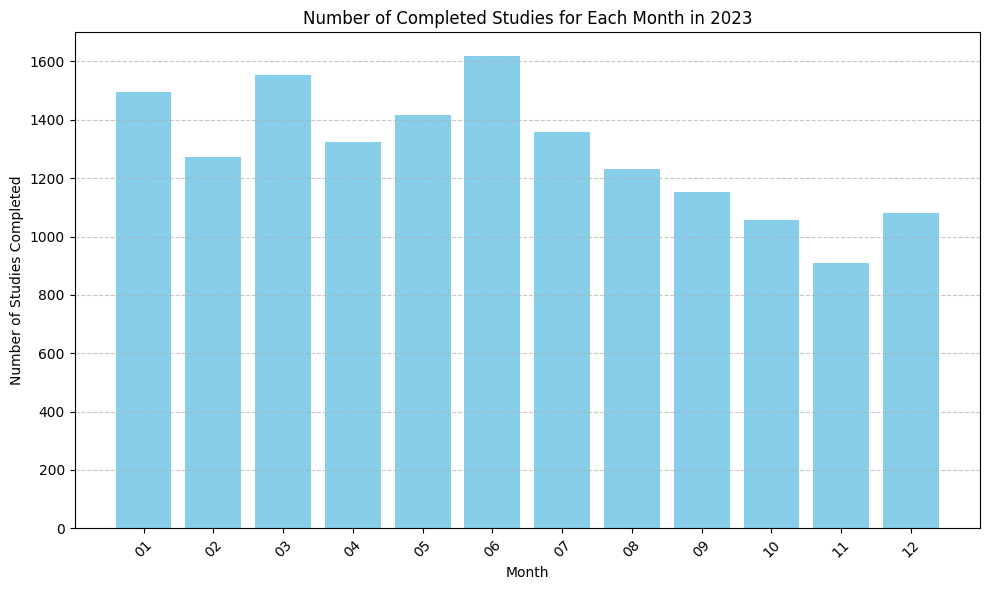

Table of Number of Completed Studies for Each Month in 2023:
Month	Number of Studies Completed
01	1494
02	1272
03	1552
04	1324
05	1415
06	1619
07	1360
08	1230
09	1152
10	1058
11	909
12	1082


<function __main__.plot_completed_studies_by_month(cleaned_rdd_clinic_trial, year)>

In [0]:
# For 2023 version
plot_completed_studies_by_month(cleaned_rdd_clinic_trial_2023, 2023)
plot_completed_studies_by_month

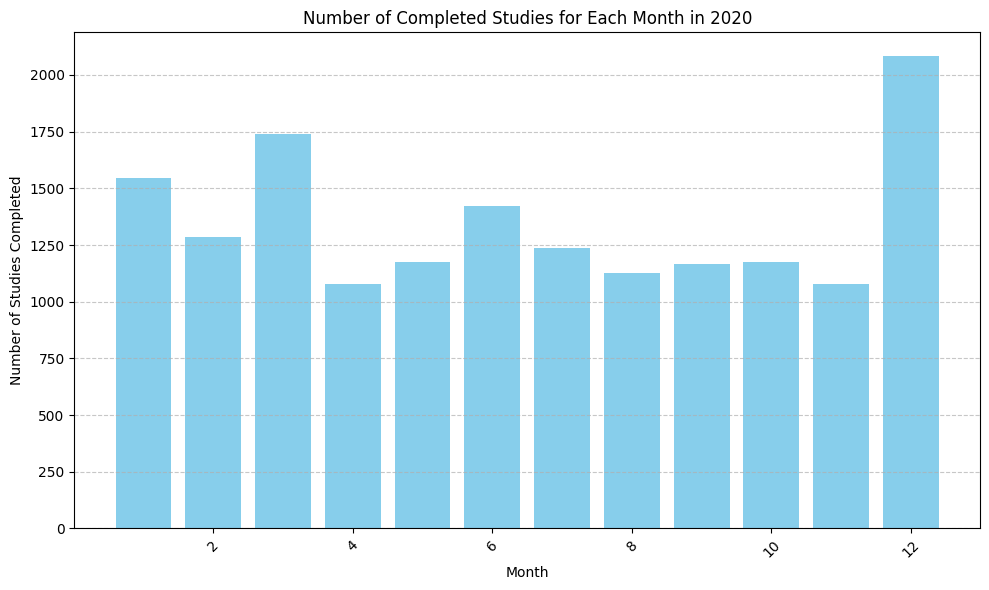

Table of Number of Completed Studies for Each Month in 2020:
Month	Number of Studies Completed
1	1544
2	1286
3	1740
4	1080
5	1176
6	1424
7	1237
8	1126
9	1167
10	1176
11	1078
12	2084


<function __main__.plot_completed_studies_by_month(cleaned_rdd_clinic_trial, year)>

In [0]:
# For 2020 version
plot_completed_studies_by_month(cleaned_rdd_clinic_trial_2020, 2020)
plot_completed_studies_by_month

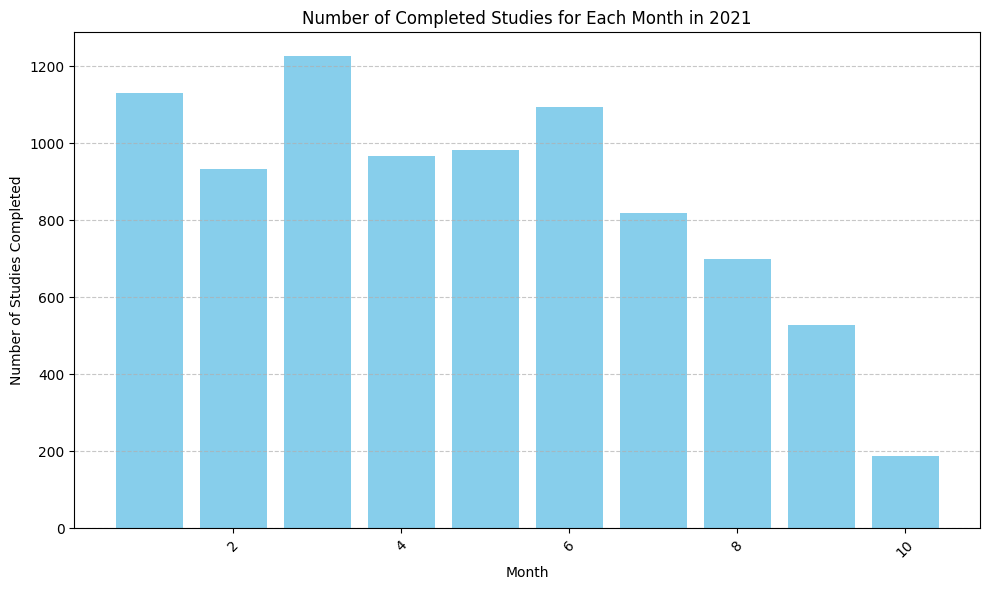

Table of Number of Completed Studies for Each Month in 2021:
Month	Number of Studies Completed
1	1131
2	934
3	1227
4	967
5	984
6	1094
7	819
8	700
9	528
10	187


<function __main__.plot_completed_studies_by_month(cleaned_rdd_clinic_trial, year)>

In [0]:
# For 2021 version
plot_completed_studies_by_month(cleaned_rdd_clinic_trial_2021, 2021)
plot_completed_studies_by_month

Find the top 10 distributions of study types for clinical trials sponsored by each pharmaceutical company

In [0]:
    # Step 1: Filter out pharmaceutical companies from the clinical trial RDD
    pharmaceutical_companies = cleaned_rdd_pharma.map(lambda row: row[0]).collect()
    clinical_trials_by_pharmaceutical_rdd = cleaned_rdd_clinic_trial_2023.filter(lambda row: row[6] in pharmaceutical_companies)

    # Step 2: Map each pharmaceutical company and study type to a tuple containing ((pharmaceutical_company, study_type), 1)
    pharma_study_type_rdd = clinical_trials_by_pharmaceutical_rdd.map(lambda row: ((row[6], row[10]), 1))

    # Step 3: Reduce by key to count occurrences of each (pharmaceutical_company, study_type) pair
    pharma_study_type_distribution_rdd = pharma_study_type_rdd.reduceByKey(lambda x, y: x + y)

    # Step 4: Swap the key-value pairs to facilitate sorting by count
    flipped_rdd = pharma_study_type_distribution_rdd.map(lambda x: (x[1], x[0]))

    # Step 5: Sort by count in descending order
    sorted_rdd = flipped_rdd.sortByKey(ascending=False)

    # Step 6: Take the top 10
    top_10 = sorted_rdd.take(10)

    # Step 7: Print the result
    for count, (pharmaceutical_company, study_type) in top_10:
        print(f"Pharmaceutical Company: {pharmaceutical_company}, Study Type: {study_type}, Count: {count}")

Pharmaceutical Company: GlaxoSmithKline, Study Type: INTERVENTIONAL, Count: 3082
Pharmaceutical Company: Pfizer, Study Type: INTERVENTIONAL, Count: 2534
Pharmaceutical Company: AstraZeneca, Study Type: INTERVENTIONAL, Count: 2230
Pharmaceutical Company: Novartis Pharmaceuticals, Study Type: INTERVENTIONAL, Count: 2146
Pharmaceutical Company: Eli Lilly and Company, Study Type: INTERVENTIONAL, Count: 1808
Pharmaceutical Company: Boehringer Ingelheim, Study Type: INTERVENTIONAL, Count: 1772
Pharmaceutical Company: Sanofi, Study Type: INTERVENTIONAL, Count: 1335
Pharmaceutical Company: Bristol-Myers Squibb, Study Type: INTERVENTIONAL, Count: 1119
Pharmaceutical Company: Novo Nordisk A/S, Study Type: INTERVENTIONAL, Count: 905
Pharmaceutical Company: AstraZeneca, Study Type: OBSERVATIONAL, Count: 784
